# Project 2 - Bézier spline interpolation

Notebook by: Reidar Kristoffersen, Viktor Sandve & Trond Skaret Johansen.

## Contents
* [Introduction](#intro)
* [Problem 1 - Properties of Bernstein polynomials](#p1)
* [Problem 2 - Properties of Bézier curves](#p2)
* [Problem 3 - Interpolation with composite cubic Bézier curves](#p3)
* [Problem 4 - Optimisation with Bézier curves](#p4)

## Introduction <a class="anchor" id="intro"></a>

In this project we study interpolation with Bézier curves. Given ordered points $\boldsymbol{p}_0, \dots, \boldsymbol{p}_n\in\mathbb{R}^d, n\in\mathbb{N}$ we define the $n$'th degree *Bézier curve* by:

$$
    \boldsymbol{c}(t) = \boldsymbol{b}_n(t; \boldsymbol{p}_0, \dots, \boldsymbol{p}_n)\overset{\textrm{def}}{=}\sum_{i=0}^n B_{i, n} (t) \boldsymbol{p}_i.
$$

Here the $B_{n, i}$'s denote the $n$'th degree *Bernstein polynomial* given by

$$
    B_{i,n}(t) = \binom{n}{i} t^i (1-t)^{n-i}, \quad i = 0, 1, \ldots, n.
$$

The cubic splines ($n=3$) will be of most interest, but we study Bézier curves in general in section 1 and 2 before turning to the cubics. We examplify our code both with some arbitrary examples and with measurements of the letter S. The final section deals with an optimisation problem with the goal of smoothening out out curve by minimising the squared acceleration.

Along with the notebook is a file "bezier.gif" which can also be generated by the code. For the notebook to display this gif the file must lie in the same folder as the notebook.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation

## Problem 1 - Properties of Bernstein polynomials <a class="anchor" id="p1"></a>

### a) Non-negativity of the Bernstein polynomials

Let $n\in \mathbb{N}$. We consider the Bernstein polynomials $B_{i,n}(t) = \binom{n}{i} t^i (1-t)^{n-i}, \quad i = 0, 1, \ldots, n$.

**Claim:** For all $t\in[0, 1]$ we have $B_{i,n}(t) \geq 0$.

**Proof:** Since $t\geq0$, so are all powers of $t$. Also binomial coefficients are positive. We obtain:

$$
B_{i,n}(t) = \overset{\geq 0}{\overbrace{\binom{n}{i}}} \overset{\geq 0}{\overbrace {t^i}} \overset{\geq 0}{\overbrace{(1-t)^{n-i}}} \geq 0.
$$

<div style="text-align: right"> ▢ </div>

### b) Recursive definition of Bernstein polynomials


**Claim:** We can, for for $0<i<n$, recursively define

$$
    B_{i,n}(t) = (1 - t)B_{i,n-1}(t) + tB_{i-1,n-1}(t), \quad t \in [0, 1].
$$

**Proof:** 
$$
    \begin{aligned}
        (1 - t)B_{i,n-1}(t) + tB_{i-1,n-1}(t)&=(1 - t)B_{i,n-1}(t) + tB_{i-1,n-1}(t) \\
        &= (1-t)\frac{(n-1)!}{i!(n-1-i)!}t^{i}(1-t)^{(n-1-i)}+t\frac{(n-1)!}{(i-1)!(n-i)!}t^{i-1}(1-t)^{(n-i)} \\
        &= t^{i}(1-t)^{n-i}(\frac{(n-1)!}{i!(n-1-i)!}+ \frac{(n-1)!}{(i-1)!(n-i)!})\\
        &= t^{i}(1-t)^{n-i}\frac{(n)!}{i!(n-i)!}(\frac{n-i}{n} +\frac{i}{n}) \\
        &=\binom{n}{i} t^i (1-t)^{n-i}=  B_{i,n}(t).
    \end{aligned}
$$

<div style="text-align: right"> ▢ </div>

Applying this to $B_{0,n}$ and $B_{n,n}$:

$$
\begin{aligned}
    B_{0,n}=(1-t)B_{0,n-1}+tB_{-1,n-1} \\
    B_{n,n}=(1-t)B_{n,n-1}+tB_{n-1,n-1}.
\end{aligned}
$$
This raises a problem as we have not defined the Bernstein polynomials for $i<0$ and $i>n$, but if we assume these to be zero we can see:

$$
\begin{aligned}
    (1-t)B_{0,n-1}+tB_{-1,n-1} = (1-t)(1-t)^{n-1} = B_{0,n}\\
    (1-t)B_{n,n-1}+tB_{n-1,n-1} = t*t^{n-1}=t^n = B_{n,n}.
\end{aligned}
$$

In conclusion, the relation holds for $0\leq i \leq n$ by assuming 0 outside this range. 

### c) Partition of unity

**Claim:** $B_{i,n}(t)$ form a partition of unity:

$$
    \sum_{i=0}^n B_{i,n}(t) = 1, \quad \textrm{ for } t\in [0,1].
$$

**Proof (by induction):**

For $n=0$ we have

$$
    \sum_{i=0}^0 B_{i,n}(t) = B_{0,0}(t) \binom{0}{0}t^0(1-t)^0=1.
$$

Assume now the statements holds true for $n=k$ and consider the case $n=k+1$. 

$$    
    \begin{aligned} 
        \sum_{i=0}^{k+1} B_{i,k+1}(t)
        &= \sum_{i=0}^{k+1} ((1-t)B_{i,k}(t) + t B_{i-1, k}(t)) \\
        &= (1-t) \overset{1}{\overbrace{\sum_{i=0}^{k} B_{i,k}(t)}} + (1-t)\overset{0}{\overbrace{B_{k+1,k}(t)}}+ 
            t \overset{1}{\overbrace{\sum_{i=1}^{k+1} B_{i-1, k}(t)}} + t \overset{0}{\overbrace{B_{-1,k}(t)}} 
        = 1. 
    \end{aligned}
$$

Where again, we enforce that $B_{i, n}(t) = 0$ for $i\notin\{0, 1, \dots, n\}$ after the second inequality to cut off the sums. 

By induction this proves our claim $
    \sum_{i=0}^n B_{i,n}(t) = 1, \quad \textrm{ for } t\in [0,1].
$

<div style="text-align: right"> ▢ </div>

### d) Derivative of the Bernstein polynomials

**Claim:** The derivative of a Bernstein polynomial is given recursivelly by:

$$
    B'_{i,n}(t) = n(B_{i-1,n-1}(t) - B_{i,n-1}(t)).
$$


**Proof:** We compute using the non-recursive definition:

$$
\begin{aligned}
B'_{i,n}(t) 
&= \frac{d}{dt}\left(\frac{n!}{i!(n-i)!} t^i (1-t)^{n-i}\right) \\ 
&= \frac{n!}{i!(n-i)!}(it^{i-1} (1-t)^{n-i} - (n-i)t^i(1-t)^{n-i-1}) \\
&= n \left(\frac{(n-1)!}{(i-1)!(n-i)!} t^{i-1}(1-t)^{n-i} - \frac{(n-1)!}{i!(n-i-1)!}t^i(1-t)^{n-i-1} \right) \\
&= n \left( \binom{n-1}{i-1} t^{i-1}(1-t)^{n-i} - \binom{n-1}{i} t^i(1-t)^{n-1-i} \right) \\ 
&=  n(B_{i-1,n-1}(t) - B_{i,n-1}(t)), i=1,\dots,n-1
\end{aligned} 
$$

For $i = 0$ and $i = n$, this works if we define $B_{-1, n-1} \equiv B_{n, n-1} \equiv 0.$

$$
\begin{aligned}
    B'_{0, n} &= -n(1-t)^{n-1} = n(B_{-1,n-1}(t) - B_{0,n-1}(t))\\
    B'_{n, n} &= nt^{n-1} = n(B_{n-1,n-1}(t) - B_{n,n-1}(t))
\end{aligned}
$$

Thus:
$$
    B'_{i,n}(t) = n(B_{i-1,n-1}(t) - B_{i,n-1}(t)), i = 0,\dots,n
$$

<div style="text-align: right"> ▢ </div>




### e) Implementation of Bernstein polynomials

Below we implement a function to evaluate $B_{i,n}$ at a given $t$. Then use this to plot $B_{i,n}$ for all $i=1,...,n$ for different values of $n$. 

In [2]:
def Bernstein(i, n, t):
    return np.math.comb(n, i) * t**i * (1-t)**(n-i)

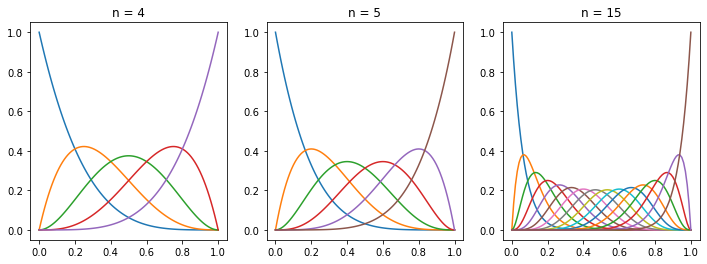

In [3]:
# We plot the polynomials for n = 4, 5, 15
t_arr = np.linspace(0, 1, 100)
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for idx, n in enumerate([4, 5, 15]):
    for i in range(0, n+1):
        ax[idx].plot(t_arr, Bernstein(i, n, t_arr))
    ax[idx].set(title=f"n = {n}")
plt.show()

Above we see our Bernstein polynomials. We note that there seems to be a "give and take" relationship between the polynomials in each subplot, as one of the lines decreases others increase and vice versa. This is in line with the result from c), that they should sum to 1 for $t\in[0,1]$.  

## Problem 2 - Properties of Bézier curves <a class="anchor" id="p2"></a>

In this problem we start working with the $n$'th degree Bézier curve defined by

$$
    \boldsymbol{c}(t) 
    = \boldsymbol{b}_n(t; \boldsymbol{p_0, \dots, p_n})
    \overset{\textrm{def}}{=} \sum_{i=0}^n B_{i, n} (t) \boldsymbol{p}_i.
$$

Where the leftmost notation is used when the points $\boldsymbol{p}_i$ are clear from context. 

We want to study composite Bézier curves. An example is the curve $\boldsymbol{s}:[0, 2]\rightarrow\mathbb{R}^d$ (where $d$ is the dimension of the points, 2 in the plots in this project) defined by:

$$
\boldsymbol{s}(t)
=
\begin{cases}
\boldsymbol{c}(t) & \textrm{ for } 0\leq t < 1 \\
\boldsymbol{d}(t-1) & \textrm{ for } 1\leq t \leq 2,
\end{cases}
$$

where the curve $\boldsymbol{d}(t) = \boldsymbol{b}_n(t; \boldsymbol{q}_0, \dots, \boldsymbol{q}_n)$ is also a degree $n$ Bézier curve.

### a) Derivatives of the Bézier curve

We compute the first two derivatives of $\boldsymbol{c}(t)$:

$$    
    \begin{aligned} 
        \boldsymbol{c}'(t) 
        
        &= \frac{d}{dt}\sum_{i=0}^n B_{i, n}(t)\boldsymbol{p}_i 
        = \sum_{i=0}^n B'_{i, n}(t)\boldsymbol{p}_i 
        
        = n\sum_{i=0}^{n} (B_{i-1, n-1}(t)-B_{i, n-1}(t))\boldsymbol{p}_i
        
        \\&= n\sum_{i=1}^{n} B_{i-1, n-1}(t)\boldsymbol{p}_i - n\sum_{i=0}^{n-1}B_{i, n-1}(t))\boldsymbol{p}_i

        = n\sum_{i=0}^{n-1} B_{i, n-1}(t)\boldsymbol{p}_{i+1} - n\sum_{i=0}^{n-1}B_{i, n-1}(t))\boldsymbol{p}_i

        \\&= n\sum_{i=0}^{n-1} B_{i, n-1}(t)(\boldsymbol{p}_{i+1} - \boldsymbol{p}_i),

        \\\\ % extra space 
        \boldsymbol{c}''(t) 
        
        &= \frac{d}{dt} 
        n\sum_{i=0}^{n-1} B_{i, n-1}(t)(\boldsymbol{p}_{i+1} - \boldsymbol{p}_i)
        
        = n(n-1) 
        \sum_{i=0}^{n-1} (B_{i-1, n-2}(t)-B_{i, n-2}(t))(\boldsymbol{p}_{i+1} - \boldsymbol{p}_i)

        \\&= n(n-1) 
        \sum_{i=1}^{n-1} B_{i-1, n-2}(t)(\boldsymbol{p}_{i+1} - \boldsymbol{p}_i)
        -n(n-1)
        \sum_{i=0}^{n-2} B_{i, n-2}(t)(\boldsymbol{p}_{i+1} - \boldsymbol{p}_i)
        
        \\&= n(n-1) 
        \sum_{i=0}^{n-2} B_{i, n-2}(t)(\boldsymbol{p}_{i+2} - \boldsymbol{p}_{i+1})
        -n(n-1)
        \sum_{i=0}^{n-2} B_{i, n-2}(t)(\boldsymbol{p}_{i+1} - \boldsymbol{p}_i)

        \\&= n(n-1) 
        \sum_{i=0}^{n-2} B_{i, n-2}(t)(\boldsymbol{p}_{i+2} - 2\boldsymbol{p}_{i+1} + \boldsymbol{p}_i).
    \end{aligned}
$$

We remark that if $\boldsymbol{c}(t)$ is a Bézier curve of degree $n$ its first derivative (velocity) is a new Bézier curve of degree $n-1$ and its second derivative (acceleration) is a degree $n-2$ Bézier curve. 


### b) Values at end points

**Computation**

We now investigate the values of the Bézier curve at the endpoints. Note first that for $i=0$ we have

$$
\begin{aligned}
    B_{0,n}(0) 
    &= \lim_{t\rightarrow 0} \binom{n}{0} t^0 (1-t)^{n} = \lim_{t\rightarrow 0} (1-t)^{n} = 1, \\
    B_{0,n}(1) 
    &= \lim_{t\rightarrow 1} \binom{n}{0} t^0 (1-t)^{n} = \lim_{t\rightarrow 1} (1-t)^{n} = 0. \\
\end{aligned}
$$

Similarly, for $i=n$, we find $B_{n,n}(0) = 0$ and $B_{n, n}(1) = 1$. For $i=1, \dots, n-1$ on the other hand, we have:

$$
\begin{aligned}
    B_{i,n}(0) 
    &= \binom{n}{i} 0^i (1-0)^{n-i} = 0, \\
    B_{i,n}(1) 
    &= \binom{n}{i} 1^i (1-1)^{n-i} = 0. \\
\end{aligned}
$$

From these computations it is clear that:

$$
    \begin{aligned}
        \boldsymbol{c}(0) 
        = \sum_{i=0}^n B_{i, n} (0) \boldsymbol{p}_i = \boldsymbol{p}_0, \\
        
        \boldsymbol{c}(1) 
        = \sum_{i=0}^n B_{i, n} (1) \boldsymbol{p}_i = \boldsymbol{p}_n. \\
    \end{aligned}
$$

**Relation to interpolation**

This property ensures that the curve interpolates the points $\boldsymbol{p}_0$ and $\boldsymbol{p}_1$. For the composite curve $\boldsymbol{s}$ defined in the introduction of this section, we see that if we choose $\boldsymbol{p}_n=\boldsymbol{q}_0$ we have obtained a continuous curve interpolating the 3 endpoints. We will refer to the endpoints of segments the *knots* of the spline. We will see later how the remaining control points (that we do not necessarily interpolate) affect the curve. 

### c) Derivatives at end points

**Claim:** For the derivatives at the endpoints we have:

1. $\boldsymbol{c}'(0) = n(\boldsymbol{p}_1 - \boldsymbol{p}_0)$
2. $\boldsymbol{c}'(1) = n(\boldsymbol{p}_n - \boldsymbol{p}_{n-1})$
3. $\boldsymbol{c}''(0) = n(n - 1)(\boldsymbol{p}_0 - 2\boldsymbol{p}_1 + \boldsymbol{p}_2)$
4. $\boldsymbol{c}''(1) = n(n - 1)(\boldsymbol{p}_n - 2\boldsymbol{p}_{n-1} + \boldsymbol{p}_{n-2})$

**Proof:** Using the results from a) and b) we find:

1. and 3. Since $i=0$, is the only $i$ for wich $B_{i,n-1}(0),B_{i,n-2}(0)\neq0$, we find:

$$
\begin{aligned}
\boldsymbol{c}'(0) 
&= n\sum_{i=0}^{n-1} B_{i, n-1}(0)(\boldsymbol{p}_{i+1} - \boldsymbol{p}_i) 
= n(\boldsymbol{p}_1 - \boldsymbol{p}_0)
\\
\boldsymbol{c}''(0) 
&= \sum_{i=0}^{n-2} B_{i, n-2}(0)(\boldsymbol{p}_{i+2} - 2\boldsymbol{p}_{i+1} + \boldsymbol{p}_i)
=n(n - 1)(\boldsymbol{p}_0 - 2\boldsymbol{p}_1 + \boldsymbol{p}_2)
\end{aligned}
$$

2. and 4. By the same argument, but for $i=n-1$, as $B_{n-1,n-1}(1)=B_{n-2,n-2}(1)= 1$, we find:

$$
\begin{aligned}
\boldsymbol{c}'(1) 
&=n\sum_{i=0}^{n-1} B_{i, n-1}(1)(\boldsymbol{p}_{i+1} - \boldsymbol{p}_i)  
= n(\boldsymbol{p}_n - \boldsymbol{p}_{n-1})
\\
\boldsymbol{c}''(1) 
&=\sum_{i=0}^{n-2} B_{i, n-2}(1)(\boldsymbol{p}_{i+2} - 2\boldsymbol{p}_{i+1} + \boldsymbol{p}_i)
= n(n - 1)(\boldsymbol{p}_n - 2\boldsymbol{p}_{n-1} + \boldsymbol{p}_{n-2})

\end{aligned}
$$

Which completes the proof.


<div style="text-align: right"> ▢ </div>




**Specifying interpolation properties at the endpoints**

While this does not directly relate to interpolation, we still can specify certain interpolation properties of the curve c at its end points. Examples of such properties are $C^1$ and $C^2$ continuity. This means that the derivatives of the spline up to the first and second order respecrively, must be contious. For this to hold at the knots we need $\boldsymbol{c}'(1) = \boldsymbol{d}'(0)$ for $C^1$ continuity and additionally $\boldsymbol{c}''(1) = \boldsymbol{d}''(0)$ for $C^2$ continuity. From the properties above we can see that this would put certain restrictions on the control points of our spline, exactly what these restricitons are will be expanded upon in task 2f). We can also see from the properites above that, changing $\boldsymbol{p}_{1}$ would change the first and second order derivative of the curve at $t=0$, and changing $\boldsymbol{p}_{2}$ would change the second order derivative at $t=0$. In addition to specifying the degree of continuity we could also specify the values first or second order derivatives at the knots, which would further restrict our control points, once again we will expand on this in later tasks. 

### d) Recursive definition of the Bézier curve

**Claim:** We have the following recursive definition

$$
    \boldsymbol{b}_n(t; \boldsymbol{p}_0, \ldots, \boldsymbol{p}_n) 
    = 
    (1 - t) \boldsymbol{b}_{n-1}(t; \boldsymbol{p}_0, \ldots, \boldsymbol{p}_{n-1}) 
    + t \boldsymbol{b}_{n-1}(t; \boldsymbol{p}_1, \ldots, \boldsymbol{p}_n).
$$

**Proof:** Using the recursion property of the Bernstein polynomials we find:

$$
\begin{aligned}
    \boldsymbol{b}_n(t; \boldsymbol{p}_0, \ldots, \boldsymbol{p}_n) 
    &= \sum_{i=0}^n B_{i, n} (t) \boldsymbol{p}_i 
    = \sum_{i=0}^{n}((1-t) B_{i, n-1} (t) + tB_{i-1, n-1} (t))\boldsymbol{p}_i\\

    &= (1-t)B_{0,n-1}\boldsymbol{p}_0+\sum_{i=1}^{n-1}((1-t) B_{i, n-1} (t) + tB_{i-1, n-1} (t))\boldsymbol{p}_i+tB_{n-1,n-1}\boldsymbol{p}_n\\
    &=(1-t)\sum_{i=0}^{n-1}B_{i, n-1} (t)\boldsymbol{p}_i + t\sum_{i=1}^{n}B_{i-1, n-1} (t)\boldsymbol{p}_i\\
    &= (1 - t) \boldsymbol{b}_{n-1}(t; \boldsymbol{p}_0, \ldots, \boldsymbol{p}_{n-1}) + t\boldsymbol{b}_{n-1}(t; \boldsymbol{p}_1, \ldots, \boldsymbol{p}_{n})
\end{aligned}
$$

Where we see that we have obtained a weighted sum of the Bézier curve through the first and last $n$ points, i.e. two Bézier curves of degree $n-1$. We remark also that for the Bézier curve between two points we get:

$$
\begin{aligned}
\boldsymbol{b}_2(t;\boldsymbol{p}, \boldsymbol{q}) 
&= (1 - t) \boldsymbol{b}_{1}(t; \boldsymbol{p}) + t\boldsymbol{b}_{1}(t; \boldsymbol{q}) 
\\&= (1 - t) \boldsymbol{p} + t\boldsymbol{q}.
\end{aligned}
$$

Which simply gives the line segment between the endpoints. 

<div style="text-align: right"> ▢ </div>





### e) De Casteljau's algorithm

The recursive definition proved above provides an algorithm for computing the Bézier curve known as de Casteljau's algorithm. The idea is as follows; begin by lines through each couple of neighbouring control points. For a Bézier curve of degree $n$ there are $n+1$ control points. Compute the distance traveled along the line between them (the fraction $t$ of the distance). This gives $n$ new points, one for each pair of neighbours. Repeat the previous step until there is $1$ point left. This is the value of the Bézier curve at time $t$.

Given the list of the $n$ control points, the function below computes the value of the Bézier curve at the point $t0$. 

The function includes some extra overhead to get nice colors coresponding to each layer of recursion. This is not an issue in this project, but would be minimized if runtime was a goal.

In [4]:
def de_Casteljau(P, t0):

    # Colors for line segment. To get different colors at different levels
    # Note: This adds some overhead, but runtime is not an issue in this project
    colors = ["grey", "blue", "green", "red"]

    # Done if only two points left
    if len(P) == 2:       
        color = "grey"
        val = (1-t0)*P[0] + t0*P[1]
        Pvecs = [(P[0], P[1], colors[0])]
    else:

        # Evaluate value
        cast1, pvecs1 = de_Casteljau(P[0:-1], t0)
        cast2, pvecs2 = de_Casteljau(P[1:], t0)
        val = (1-t0)*cast1 + t0*cast2

        # Handle line segments
        if len(P) - 1 > len(colors):
            color = "grey"
        else:
            color = colors[len(P)-2]
        Pvecs = pvecs1 + pvecs2 + [(cast1, cast2, color)]

    return val, Pvecs

def plot_Bezier(points, t0=1/3):
    # Compute Bezier curve
    t = np.linspace(0, 1, 100)
    Bezier_points = np.array([de_Casteljau(points, t_val)[0] for t_val in t])

    # Plot the Bezier curve
    plt.plot(Bezier_points[:, 0], Bezier_points[:, 1])

    # Add the control points
    for idx, point in enumerate(points):
        plt.annotate(rf"$p_{idx}$", point, textcoords="offset points", xytext=(0,5), ha='center', fontsize=12, color="grey")
        plt.scatter(point[0], point[1], color="grey")

    # Add the lines corresponding to t0 = 1/3
    _, Pvecs = de_Casteljau(points, t0)
    for tt in Pvecs:
        plt.plot([tt[0][0], tt[1][0]], [tt[0][1], tt[1][1]], color = tt[2], linestyle = "--")

    # Adjust plot bounds
    x_coords, y_coords = zip(*points)
    plt.xlim(min(x_coords) - 1, max(x_coords) + 1)
    plt.ylim(min(y_coords) - 1, max(y_coords) + 1)

    # Show the plot
    plt.show()

We demonstrate the algorithm for quartic Bézier curve defined by the control points:

$$
\boldsymbol{p}_0 = \begin{pmatrix} 0  \\ 0 \end{pmatrix}, 
\boldsymbol{p}_1 = \begin{pmatrix} -1 \\ 5 \end{pmatrix}, 
\boldsymbol{p}_2 = \begin{pmatrix} 4  \\ 4 \end{pmatrix}, 
\boldsymbol{p}_3 = \begin{pmatrix} 9  \\ 3 \end{pmatrix}, 
\boldsymbol{p}_4 = \begin{pmatrix} 8  \\ 8 \end{pmatrix}.
$$

We show the lines made in the recursion. Lines from the same layer share color.

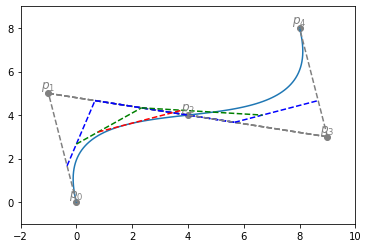

In [5]:
# Define control points
p0 = np.array([0, 0])
p1 = np.array([-1, 5])
p2 = np.array([4, 4])
p3 = np.array([9, 3])
p4 = np.array([8, 8])
points = [p0, p1, p2, p3, p4]

# Make the plot
plot_Bezier(points)

Here we see how each color corresponds to a layer of recursion. At the bottom we compute the value 1/3 of the way between the control points. These are the grey lines. With the new points, we get three blue lines on which we walk 1/3 of the distance to get new points and two green lines. Between these we walk 1/3 again along the red line to obtain the point on the spline. 

#### Bonus animation

We also animate the algorithm, to make it even clearer what is going on. To make the animation, uncomment the bottom line.

In [6]:
# The following function makes an animation of the algorithm ...
def animate_spline(points, gif_name = "bezier"):

    # Initialize plot and adjust plot bounds
    fig, ax = plt.subplots()
    x_coords, y_coords = zip(*points)
    plt.xlim(min(x_coords) - 1, max(x_coords) + 1)
    plt.ylim(min(y_coords) - 1, max(y_coords) + 1)

    # Initialize values
    t_vals = np.linspace(0, 1, 100)

    # call this function for every frame in the animation
    def animate(t0):

        ax.cla()

        # Add the control points
        for idx, point in enumerate(points):
            plt.annotate(rf"$p_{idx}$", point, textcoords="offset points", xytext=(0,5), ha='center', fontsize=12, color="grey")
            plt.scatter(point[0], point[1], color="grey")

        # Compute and plot the curve so far
        t = np.linspace(0, t0, 2+int(100*t0))
        Bezier_points = np.array([de_Casteljau(points, t_val)[0] for t_val in t])
        plt.plot(Bezier_points[:, 0], Bezier_points[:, 1], color = "black")
        plt.scatter(Bezier_points[-1, 0], Bezier_points[-1, 1], color = "black")

        # Add the lines corresponding to t0
        _, Pvecs = de_Casteljau(points, t0)
        for tt in Pvecs:
            plt.plot([tt[0][0], tt[1][0]], [tt[0][1], tt[1][1]], color = tt[2], linestyle = "--")

    # Make and save the animation
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=t_vals, repeat=False)
    frames_per_second = 1/(t_vals[1]-t_vals[0])
    ani.save(f'{gif_name}.gif', fps = frames_per_second)

# animate_spline(points, gif_name="bezier")

The code produces the animation seen below:

![](bezier.gif)

Again, we see how we walk along lines between control points to obtain new points. The curve is traced out by the point on the final red line.

### f) Increasing continuity class

We consider a composite Bézier curve $\boldsymbol{s}$ as mentioned previously. We assume we want $\boldsymbol{s}(t)$ to be $C^k$-continuous for $k=0,1,2$. In this problem we discuss how increasing the continuity class increases the dependent properties we must impose. 

**1) What are the critical/interesting points of $s(t)$ to investigate for the property to be a $C^k$ function?**

The interesting points to inevstigate are the connection points between different splines, i.e. the knots. This is because the curves defining the segments (Bézier curves) for $t\in(0, 1)$ are linear combinations of polynomials which are $C^\infty$-continuous. As the curves are as continuous as they can be between the knots, the knots are the points of interests. If we lach $C^0$-continuity is a jump between splines. Lacking $C^1$ continuity means that tangents dont change continously when passing a knot. This can be seen as a corner-like point. 

Finally, since $\boldsymbol{s}(t)$ is composed of $2$ Bézier curves, there is one point of interest, the knot between them. 

**2) Which properties have to hold for continuity ($k = 0$)?**

We need the curves to meet, that is:

$$
\boldsymbol{c}(1) = \boldsymbol{d}(0) \Leftrightarrow  \boldsymbol{p}_n = \boldsymbol{q}_0
$$

Imposing this means we "loose" one control point. 

**3) Which properties have to hold for $\boldsymbol{s}(t)$ to be continuously differentiable ($k = 1$)?**

We firstly still need $C^0$, so $\boldsymbol{p}_n = \boldsymbol{q}_0$. For the derivatives to coincide we need:

$$
\boldsymbol{c}'(1) = \boldsymbol{d}'(0) 
\Leftrightarrow n(\boldsymbol{p}_n - \boldsymbol{p}_{n-1}) = n(\boldsymbol{q}_1 - \boldsymbol{q}_0) 
\Leftrightarrow \boldsymbol{p}_{n-1} = 2\boldsymbol{q}_{0} -\boldsymbol{q}_{1}.
$$

We see that we loose control over one more control point.

**4) Which properties have to hold for $\boldsymbol{s}(t)$ to be twice continuously differentiable ($k = 2$)?**

To be $C^2$ we must at least be $C^0, C^1$, so again $\boldsymbol{p}_n = \boldsymbol{q}_0$ and $ \boldsymbol{p}_{n-1}=2\boldsymbol{q}_{0} -\boldsymbol{q}_{1}$. Having this, we find for the contidion on the acceleration that:

$$
\begin{aligned}
\boldsymbol{c}''(1) = \boldsymbol{d}''(0) 
&\Leftrightarrow 
n(n-1)(\boldsymbol{p}_n - 2\boldsymbol{p}_{n-1} + \boldsymbol{p}_{n-2}) = n(n-1)(\boldsymbol{q}_0 - 2\boldsymbol{q}_{1} + \boldsymbol{q}_{2})  
\\&\Leftrightarrow \boldsymbol{p}_{n-2} = \boldsymbol{q}_0 - 2\boldsymbol{q}_{1} + \boldsymbol{q}_{2} - (\boldsymbol{p}_n - 2\boldsymbol{p}_{n-1}) = 4\boldsymbol{q}_0 - 4\boldsymbol{q}_{1} + \boldsymbol{q}_{2}
\end{aligned}
$$

Where we used the  $\boldsymbol{p}_n = \boldsymbol{q}_0$ and $\boldsymbol{p}_{n-1} = 2\boldsymbol{q}_{0} -\boldsymbol{q}_{1}$ in the last equality. Again, we see that going $1$ up in class of continuity costs $1$ control point.



**5) Let $n = 3$. How many degrees of freedom do we have left to interpolate data points $\boldsymbol{d}_0, \boldsymbol{d}_1, \boldsymbol{d}_2 \in \mathbb{R}^d$ with $\boldsymbol{s}(t)$ ($\boldsymbol{s}(h) = \boldsymbol{d}_h$, $h = 0, 1, 2$) for $\boldsymbol{s} \in C^1$? In other words, how many of the points $\boldsymbol{p}_0, \ldots, \boldsymbol{p}_3, \boldsymbol{q}_0, \ldots, \boldsymbol{q}_3$ can we still choose freely? How many are left for $\boldsymbol{s} \in C^2$?**

To interpolate $\boldsymbol{d}_0, \boldsymbol{d}_1, \boldsymbol{d}_2$ as described above and be continuous we must put $\boldsymbol{p}_{0}=\boldsymbol{d}_{0}, \boldsymbol{p}_{3}=\boldsymbol{q}_{0}=\boldsymbol{d}_{1}$ and $\boldsymbol{q}_{3}=\boldsymbol{d}_{2}$. 

To get $\boldsymbol{s}\in C^1$ we must put $\boldsymbol{p}_{2}=2\boldsymbol{q}_0-\boldsymbol{q}_1$. 

To get $\boldsymbol{s}\in C^2$ we must put $\boldsymbol{p}_{1}=4\boldsymbol{q}_0-4\boldsymbol{q}_1+\boldsymbol{q}_2$.

In conclusion, we can choose 3 points (eg. $\boldsymbol{p}_1, \boldsymbol{q}_1, \boldsymbol{q}_2$) freely in the $C^1$ case and 2 points (eg. $\boldsymbol{q}_1, \boldsymbol{q}_2$) freely in the $C^2$ case.

We remark that if we extend this composite curve with more splines before the *tail* $\boldsymbol{q}$, we have no control over these beyond the knots we interpolate if we impose the strict $C^2$-continuity. Briefly this is because the control points here will be completelly decided by the $\boldsymbol{p}_i$'s and the knots. 

**6) What changes if we want $\boldsymbol{s}(t)$ to be periodic, i.e., $\boldsymbol{s}(t) = \boldsymbol{s}(2 + t)$ for all $t$ for the continuously differentiability case ($k = 1$)?**

In this case we must enforce for interpolation and continuity enforce $   \boldsymbol{p}_0=\boldsymbol{q}_3=\boldsymbol{d}_0(=\boldsymbol{d}_2)$ and $   \boldsymbol{p}_3=\boldsymbol{q}_0=\boldsymbol{d}_1$.

This leaves us with the four points $\boldsymbol{p}_1, \boldsymbol{p}_2, \boldsymbol{q}_1, \boldsymbol{q}_2.$ Finally we want to impose continuous derivative at the two junctions. We find:

$$
\begin{aligned}
    &\boldsymbol{d}'(1) = \boldsymbol{c}'(0) 
    \Leftrightarrow n(\boldsymbol{q}_3 - \boldsymbol{q}_{2}) = n(\boldsymbol{p}_1 - \boldsymbol{p}_0) 
    \Leftrightarrow \boldsymbol{q}_{2} = 2\boldsymbol{p}_{0} -\boldsymbol{p}_{1} \\

    &\boldsymbol{d}'(0) = \boldsymbol{c}'(1) 
    \Leftrightarrow n(\boldsymbol{q}_1 - \boldsymbol{q}_0) = n(\boldsymbol{p}_3 - \boldsymbol{p}_2) 
    \Leftrightarrow \boldsymbol{p}_{2} = 2\boldsymbol{q}_{0} -\boldsymbol{q}_{1}. \\
\end{aligned}
$$

Having imposed this, our two remaining control points are for instance $\boldsymbol{p}_1, \boldsymbol{q}_1$. Note that one can choose other points to be left with, but the two equations above remain, so we are left with 2 degrees of freedom. 

We remark that if we now impose $C^2$-continuity, we loose these two as well. This means that to have a $C^2$-continuous periodic cubic spline, you only get to choose the knots. 

## Problem 3 - Interpolation with composite cubic Bézier curves <a class="anchor" id="p3"></a>

We consider the Bézier curves that yield cubic polynomials, i.e. $\boldsymbol{b}_3(t; \boldsymbol{p}_0, \boldsymbol{p}_1, \boldsymbol{p}_2, \boldsymbol{p}_3)$. Stiching such together gives a *spline*. We define

$$
    \boldsymbol{B}(t) = \{ \boldsymbol{b}_3(t-i+1; \boldsymbol{p}_{0, i}, \boldsymbol{p}_{1, i}, \boldsymbol{p}_{2, i}, \boldsymbol{p}_{3, i}),
    \textrm{ for } i-1\leq t < i \textrm{ and each } i = 1, \dots, m.
$$

### a) Implementing the composite Bézier function

Below is the implementation as well as a useful function to plot the spline. 

In [7]:
def composite_Bezier(P, t0):

    # Rounds t down, get index of segment
    segment = int(t0-10**(-10)) 
    points = P[segment]

    # Return evaluation
    p, _ = de_Casteljau(points, t0 - segment)
    return p

def plot_spline(point_matrix, show_points = True, ax = None):

    # Initialise figure if needed
    if ax is None:
        fig, ax = plt.subplots(1)

    # Compute curve
    num_segments = len(point_matrix)
    t = np.linspace(0, num_segments, 100)
    Bezier_points = np.array([composite_Bezier(point_matrix, t_val) for t_val in t])

    # Plot the Bezier curve
    ax.plot(Bezier_points[:, 0], Bezier_points[:, 1])

    # Add the control points
    if(show_points):
        for i, points in enumerate(point_matrix):
            for j, point in enumerate(points):
                formatted_string = rf"$p_{{{j}, {i}}}$"
                ax.annotate(formatted_string, point, textcoords="offset points", xytext=(0,5), ha='center', fontsize=12, color="grey")
                ax.scatter(point[0], point[1], color="grey")

    # Show the plot unless axis specified (assume then more is to be done with the figure)
    if ax is None:
        plt.show()

As a first example, we test our function on the 3-segment cubic composite B spline given by:

$$
\begin{aligned}
\boldsymbol{p}_{0,1} &= \begin{pmatrix} -1 \\ 0 \end{pmatrix} ,&
\boldsymbol{p}_{1,1} &= \begin{pmatrix} -1 \\1/3\end{pmatrix} ,&
\boldsymbol{p}_{2,1} &= \begin{pmatrix}-1/3 \\1\end{pmatrix} ,&
\boldsymbol{p}_{3,1} &= \begin{pmatrix} 0 \\ 1 \end{pmatrix} ,\\
\boldsymbol{p}_{0,2} &= \begin{pmatrix} 0 \\ 1 \end{pmatrix} ,&
\boldsymbol{p}_{1,2} &= \begin{pmatrix} 1/3 \\ 1 \end{pmatrix} ,&
\boldsymbol{p}_{2,2} &= \begin{pmatrix} 1 \\ 1/3 \end{pmatrix} ,&
\boldsymbol{p}_{3,2} &= \begin{pmatrix} 1 \\ 0 \end{pmatrix} ,\\
\boldsymbol{p}_{0,3} &= \begin{pmatrix} 1 \\ 0 \end{pmatrix} ,&
\boldsymbol{p}_{1,3} &= \begin{pmatrix}  1 \\ -1/3 \end{pmatrix} ,&
\boldsymbol{p}_{2,3} &= \begin{pmatrix} 1/3 \\ -1 \end{pmatrix} ,&
\boldsymbol{p}_{3,3} &= \begin{pmatrix} 0 \\ -1 \end{pmatrix}.
\end{aligned} 
$$

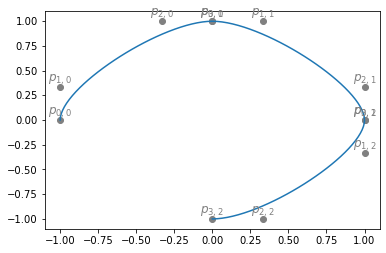

In [8]:
# Define points
P = np.array([[[-1, 0], [-1, 1/3], [-1/3, 1], [0, 1]],
               [[0, 1],  [1/3, 1],  [1, 1/3],  [1, 0]],
               [[1, 0],  [1, -1/3], [1/3, -1], [0, -1]]])
  
# Make the plot
plot_spline(P)

Above we see the 3-segment cubic composite B spline given by our control points. We notice that the spline interpolates all the endpoints of the segments, as the last control point of one segment is equal to the first in the next segment in our case, this gives us a continous curve. 

### b) Periodic composite Bézier curves

We want an algorithm for computing periodic cubic Bézier curves from just the points of interconnection $\boldsymbol{a}_0, \dots, \boldsymbol{a}_{m-1}$ and the derivatives (velocities) $\boldsymbol{v}_0, \dots, \boldsymbol{v}_{m-1}$ at said points. In other words, we impose these properties:

$$
\begin{aligned}
\boldsymbol{B}(0) &= \boldsymbol{B}(m), \\
\boldsymbol{B}'(0) &= \boldsymbol{B}'(m), \\
\boldsymbol{B}(i) &= \boldsymbol{a}_i, i = 0, \dots, m-1 \\
\boldsymbol{B}'(i) &= \boldsymbol{v}_i, i = 0, \dots, m-1.
\end{aligned}
$$

Before presenting the algorithm, we need to find an expression for the points. Begin by noting that $\boldsymbol{p}_{0, i+1} = \boldsymbol{a}_{i}$ for $i=0, 1, \dots, m-1$  and that the continuity of the spline gives $\boldsymbol{p}_{3, i} = \boldsymbol{p}_{0, i+1} = \boldsymbol{a}_{i}$ for $i= 1, \dots, m-1$ and periodicity gives $\boldsymbol{p}_{3, m} = \boldsymbol{p}_{0, 1} = \boldsymbol{a_0}$. This leaves 2 points for each segment. 

To impose the conditions on the derivative, we first remark that defining the derivative at the point $t=i$ is only meaningful if the function is differentiable at that point. We get:

$$
\begin{aligned}
\boldsymbol{v}_i
=\boldsymbol{B}'(i) 
&= \lim_{h\rightarrow 0}\frac{\boldsymbol{B}(i+h)-\boldsymbol{B}(i)}{h}
\\&= \lim_{h\rightarrow 0^-}\frac{\boldsymbol{B}(i+h)-\boldsymbol{B}(i)}{h} = \textrm{derivative of segment to the left}
\\&= \lim_{h\rightarrow 0^+}\frac{\boldsymbol{B}(i+h)-\boldsymbol{B}(i)}{h} = \textrm{derivative of segment to the right}.
\end{aligned}
$$

In other words, to impose the property $\boldsymbol{B}'(i)=\boldsymbol{v}_i$ in the i'th knot, we must require $C^1$-continuity at the knots. From problem 2c) we have expressions of these derivatives using both the end of the previous segment and the beginning of the next. For $i=1, \dots, m-1$ we find:

$$
\begin{aligned}
    \boldsymbol{v}_i 
    = \boldsymbol{B}'(i) 
    = 3(\boldsymbol{p}_{3, i} - \boldsymbol{p}_{2, i})
    = 3(\boldsymbol{p}_{1, i+1} - \boldsymbol{p}_{0, i+1}).
\end{aligned}
$$

Using again $\boldsymbol{p}_{3, i}=\boldsymbol{p}_{0, i+1}=\boldsymbol{a}_i$ we find

$$
\begin{aligned}
    \boldsymbol{p}_{2, i} 
    &= \boldsymbol{a}_i-\boldsymbol{v}_i / 3 \\
    \boldsymbol{p}_{1, i+1} 
    &= \boldsymbol{a}_i+\boldsymbol{v}_i / 3.
\end{aligned}
$$

For $i=0$ we are imposing $\boldsymbol{v}_i=\boldsymbol{B}(0)=\boldsymbol{B}(m)$ which gives (using $\boldsymbol{p}_{3, m}=\boldsymbol{p}_{0, 1}=\boldsymbol{a}_0$):

$$
\begin{aligned}
    \boldsymbol{v}_0 
    &= \boldsymbol{B}'(m) 
    = 3(\boldsymbol{p}_{3, m} - \boldsymbol{p}_{2, m})
    = \boldsymbol{B}'(0)
    = 3(\boldsymbol{p}_{1, 1} - \boldsymbol{p}_{0, 1}). \\
    \Rightarrow 
    \boldsymbol{p}_{2, m} 
    &= \boldsymbol{a}_0-\boldsymbol{v}_0 / 3 \\
    \boldsymbol{p}_{1, 1} 
    &= \boldsymbol{a}_0+\boldsymbol{v}_0 / 3.
\end{aligned}
$$



In [9]:
def interpolate_periodic(A, V):
    """
    Computing the control points of a periodic composite Bezier curve given control points at speed values.

    Input:
    A: ndarray, controlpoints
    V: ndarray, "speed" or first derivatives in said points

    Returns:
    P: ndarray, matrix with the computed control points.
    """
    
    # Number of segments:
    m = len(A)
    d = A.shape[1] # dimension, usually 2
    
    # Initialise point storage
    P = np.zeros((m,4,d))

    #Setting P[i,0] to be the interpolation points
    P[::,0] = A

    #Using continuity and periodicity to set the ending points
    P[:-1,3] = A[1::]
    P[m-1,3] = A[0]

    #Setting P[i,1] and P[i, 2] from the velocity values
    P[::,1] = P[::,0] + V/3
    P[::,2] = P[::,3] - np.roll(V, -d)/3 # roll one velocity to the back...

    return P

**Smoothness of $\boldsymbol{B}$**

From the discussion above, we have imposed $C^1$ continuity at the knots. The curve is $C^\infty$-continuous elsewhere. 

We have that curve $B$ is smooth in the first derivative but not in the second, $B \in C^1$. Intuitively, requiring $C^2$ is not possible when we also impose values for the derivative and periodicity, since we have "used up" our degrees of freedom. 

We prove the claim that the curve is not necesarily $C^2$-continuous. One example where it is is of course in the case $\boldsymbol{a}_i=\boldsymbol{v}_i=\boldsymbol{0}$ for $i=0, \dots, m-1$, which is not very interesting. We now provide a proof by counterexample that it is not in general $C^2$-continuous. 

*Proof:*

Assume for simplicity that the spline is in $\mathbb{R}$, that it is a 2-segment periodic spline given by the points $a_0, a_1$ and velocities $v_0=v_1=1$. Let ${p}_i, {q}_i$ for $i=0, \dots, 3$ be the control points determined as above. Assume for contradiction that the spline is twice continuously differentiable at the knot at ${p}_3={q}_0$. From problem 2f) part 4 we obtain:

$$
\begin{aligned}
    {p}_{1} &= 4 {q}_0-4{q}_1 + {q}_2 \\
    ({p}_{0}+v_0/3) &= 4 {q}_0-4(q_0+v_1/3) + (p_0-v_0/3) \\
    1/3 &= -5/3. \\
\end{aligned}
$$

This is a contradiction, so the spline was not $C^2$-continuous. 
<div style="text-align: right"> ▢ </div>

**Testing the implementation**
Here we simply test the computation of the controlpoints with some test values:

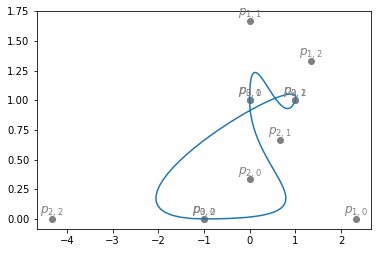

In [10]:
test_A = np.array([[-1,0],[0,1],[1,1]])
test_V = np.array([[10,0],[0,2],[1,1]])

# Interpolate with the new function to create the point matrix
P = interpolate_periodic(test_A,test_V)

#Then we can use composite_Bezier(P, t) to plot the result
plot_spline(P)

Here we see clearly the continuity at the knots. We also notice how the two control points that are neighbour to a knot are mirrored about the knot. This is exactly as we expected, as we derived that they equal knot $\pm$ one third of the velocity at the knot. This derivation also tells us that they lie on the tangent at the knot, which also seems plausible on the figure. 


### c) Demonstraion on our favorite letter

The code below shows the result from using our function on measurements of the letter S. 

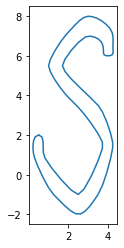

In [11]:
# Measurements of letter
S_A = np.array([[0.5, 2], [0.75, 1], [2.5, -1], [3.75, 1.5], [2.5, 3.4], [2,3.9], [1,5.5], [2,7.2], 
                [3, 8], [4, 7.5],[4.25, 6.5], [4, 6], [3.75, 6.5], [3, 7], [1.7, 5.5], [3, 4], 
                [3.5, 3.5], [4.25, 1.5], [3.5, -1], [2.5, -2], [1.25,-1], [0.25, 1]])
S_V = np.array([[1, 0], [0.2, -1], [1, 0], [0, 1], [-1, 1], [-1, 1], [0, 1], [1,1], [1, 0], [1, -1], 
                [0, -1], [-1, 0], [-0.2, 1], [-1, 0], [0, -1], [1, -1], [1,-1], [0, -1], [-1,-1.5], 
                [-1, 0], [-1,1], [-0.2, 1]])

# Perform interpolation to compute all control points
S = interpolate_periodic(S_A,S_V)

# Make plot using plot_spline
fig, ax = plt.subplots(1)
plot_spline(S, show_points=False, ax=ax)
ax.set(aspect='equal')
plt.show()

We see that the result is a (relativelly) smooth outline of our letter. There are some rough edges at the knots (the control points in A). This is due to difficulty in measuring the "velocity" of a drawing. In the final section of this project we look at an optimisation problem that smooths out these edges. 

### d) Transforming the letter

We now define 4 new curves from the letter. We name them $Q, R, S, T$ and let them have components:


$$
\begin{aligned}
q_{i,j} &= 2p_{i,j}
\\\\
r_{i,j} &=
\begin{pmatrix} 
    \cos\left(\frac{\pi}{8}\right) & -\sin\left(\frac{\pi}{8}\right) \\ 
    \sin\left(\frac{\pi}{8}\right) & \cos\left(\frac{\pi}{8}\right) 
\end{pmatrix}p_{i,j}
\\\\
s_{i,j} &= 
\begin{pmatrix} 
    1 & \frac{1}{2} \\ 
    1 & 0 
\end{pmatrix}
p_{i,j} + \frac{1}{3} 
\begin{pmatrix} 
    1 \\ 
    1 
\end{pmatrix}
\\\\
t_{i,j} &= 
\begin{pmatrix} 
    -1 & -\frac{2}{3} \\ 
    1 & 0 
\end{pmatrix}
p_{i,j} + \frac{1}{4}
\begin{pmatrix} 
    1 \\ 
    -1 
\end{pmatrix}.
\end{aligned}
$$

The result is given below the following code.

In [12]:
def compute_transformations(P):

    # Make the transformed point arrays
    Q = 2 * np.copy(P)
    R = np.copy(P)
    for i in range (4):
        for j in range(len(P)):
            R[j][i] = np.dot(np.array([[np.cos(np.pi/8), -np.sin(np.pi/8)], [np.sin(np.pi/8), np.cos(np.pi/8)]]), P[j][i])
    S2 = np.copy(P)
    for i in range (4):
        for j in range(len(P)):
            S2[j][i] = np.dot(np.array([[1, 1/2], [1, 0]]), P[j][i]) + np.array([1/3, 1/3])
    T = np.copy(P)
    for i in range (4):
        for j in range(len(P)):
            T[j][i] = np.dot(np.array([[-1, -2/3], [1, 0]]), P[j][i]) + np.array([1/4, -1/4])


    transformations = [{"P" : Q, "label" : "Q"}, {"P" : R, "label" : "R"}, {"P" : S2, "label" : "S"}, {"P" : T, "label" : "T"}]

    return transformations

def transformation_experiment(P):

    transformations = compute_transformations(P)

    shape = (1, len(transformations))
    fig, axs = plt.subplots(1, len(transformations), figsize = (3*shape[1], 3*shape[0]))
    for i, ax in enumerate(axs.flat):
        # Store the first axis to use it as standard scale
        if i == 0:
            ax0 = ax

        # Plot
        plot_spline(transformations[i]["P"], show_points=False, ax=ax)

        # Set titles
        ax.set(title=transformations[i]["label"], aspect='equal')

    plt.tight_layout()
    plt.show()


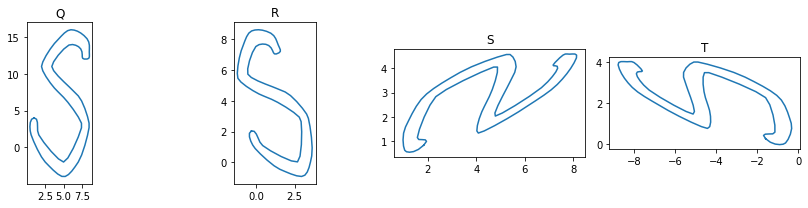

In [13]:
transformation_experiment(S)


From the plot above we can see the curves Q, R, S and T given in the task, which are transformed curves of our original S.

* Q is the easiest to interpret as it is just scaled by a factor of 2.

* R seems to have kept the original shape, but is rotated counterclockwise by an angle $\pi/8 < 90^\circ$. 

* S is both rotated clockwise by $90^\circ$, and the original shape is mirrored and deformed.This means the transformation represents a mirorring, rotation and rescaling.

* T is both rotated counter clockwise by $90^\circ$, and the original shape is once again deformed. This means T is also both a rotation and rescaling of the axes of the original curve.

To us these transformations resemble shadows of the letter from different light sources. One could imagine transformations like these could be used to create such "shadows" of letters for various fonts.

## Problem 4 - Optimisation with Bézier curves <a class="anchor" id="p4"></a>


Assume we have a composite cubic Bézier curve $\boldsymbol{B}(t)$ (here just not necessarily periodic) with $m$ segments, i.e., control points $\boldsymbol{p}_{0,1}$, $\boldsymbol{p}_{1,1}$, $\boldsymbol{p}_{2,1}$, $\boldsymbol{p}_{3,1}$, $\boldsymbol{p}_{0,2}$, $\boldsymbol{p}_{1,2}$, $\ldots$, $\boldsymbol{p}_{3,m}$. We denote its segments by $\boldsymbol{c}_i: [i - 1, i] \to \mathbb{R}^2$, for $i = 1, \ldots, m$. Then $\boldsymbol{B}(t)$ is defined on $[0, m]$. Assume further that $\boldsymbol{B}(t)$ is $\boldsymbol{C}^1$.



### a) "Rephrasing" the data

By continuity of $\boldsymbol{B}(t)$ being continuous, we have $\boldsymbol{p}_{3,i} = \boldsymbol{p}_{0,i+1}$ for $i = 1, \ldots, m-1$, so we do not need to "store" the redundant $\boldsymbol{p}_{3,i}$.

Similarly, by differentiability, we can express $\boldsymbol{p}_{2,i}$ using $\boldsymbol{p}_{0,i+1}$ and $\boldsymbol{p}_{1,i1}$ for each $i = 1, \ldots, m - 1$. We find as in 2f) point 6:

$$
\boldsymbol{p}_{2, i} = 2\boldsymbol{p}_{0, i+1}  - \boldsymbol{p}_{1, i+1}.
$$

The "data" we store for $\boldsymbol{p}_{2,i}$ and/or $\boldsymbol{p}_{1,i+1}$ is now just one vector in $\mathbb{R}^d$ (namelly one of the points). We can also phrase this information in terms of the velocity $\boldsymbol{v}_{i+1}$ at $\boldsymbol{p}_{0,i+1}$, i.e., such that from this velocity we can recover both "neighboring" points. Using the derivative of $\boldsymbol{B}(t)$, we can conclude as we did in 3b:

$$
\boldsymbol{p}_{1, i+1} = \boldsymbol{p}_{0, i+1} + \frac{\boldsymbol{v}_{i+1}}{3}
\textrm{, and } 
\boldsymbol{p}_{2, i} =  \boldsymbol{p}_{0, i+1} - \frac{\boldsymbol{v_{i+1}}}{3}.
$$

Thus one can also compute all the control points, excluding our degrees of freedom, from one list of interpolation points, and one of the velocities at these points.

### b) Minimizing the squared acceleration

Our next goal is to minimize the (squared) acceleration of the curve, namelly the cost function:

$$
    F(\boldsymbol{P}) 
    \overset{\textrm{def}}{=} 
    \int_{0}^{m} \|\boldsymbol{B}''(t)\|_2^2 \, dt,
$$

with respect to the remaining control points $
    \boldsymbol{P} = [\boldsymbol{p_{0,1}, p_{1,1}, p_{0,2}, p_{1,2}, \ldots, p_{0,m-1}, p_{1,m-1}, p_{0,m}, p_{1,m}, p_{2,m}, p_{3,m}}].
$

For simplicity, we first consider one segment, i.e., for $\boldsymbol{q_0, q_1, q_2, q_3} \in \mathbb{R}^2$, we consider the cubic Bézier curve $\boldsymbol{b_3(t; q_0, q_1, q_2, q_3)}$.


**Computing the integral**

Our simplified problem is to find the gradient of:

$$
\tilde{F}(\boldsymbol{q}_0, \boldsymbol{q}_1, \boldsymbol{q}_2, \boldsymbol{q}_3) \overset{\textrm{def}}{=} \int_0^1 \lVert \boldsymbol{b}_3''(t; \boldsymbol{q}_0, \boldsymbol{q}_1, \boldsymbol{q}_2, \boldsymbol{q}_3) \rVert_2^2 dt
$$

We begin by deriving a closed form of the integral. We find first the second derivative:

$$
\begin{aligned}
    \boldsymbol{b}''(t) 
    &= 3(3-1)\sum_{i=0}^{3-2} B_{i, 3-2}(t)(\boldsymbol{q}_{i+2} - 2\boldsymbol{q}_{i+1} + \boldsymbol{q}_i)
    = 6\sum_{i=0}^{1} B_{i, 1}(t)(\boldsymbol{q}_{i+2} - 2\boldsymbol{q}_{i+1} + \boldsymbol{q}_i)
    \\&= 6((1-t)(\boldsymbol{q}_2-2\boldsymbol{q}_1+\boldsymbol{q}_0))
    + t(\boldsymbol{q}_3-2\boldsymbol{q}_2+\boldsymbol{q}_1)
    \\&= 6t\underset{\boldsymbol{p}}{\underbrace{(\boldsymbol{q}_3-3\boldsymbol{q}_2+3\boldsymbol{q}_1-\boldsymbol{q}_0)}}
    +\underset{\boldsymbol{q}}{\underbrace{
    \boldsymbol{q}_2-2\boldsymbol{q}_1+\boldsymbol{q}_0}}.
\end{aligned}
$$

It has norm squared given by (using dot product properties of the euclidean norm):

$$
\begin{aligned}
    \lVert\boldsymbol{b}''(t) \rVert_2^2
    = \lVert 
    6t\boldsymbol{p} + \boldsymbol{q}
    \rVert_2^2
    = 36(t^2\boldsymbol{p}^2 + 2t\boldsymbol{p}\boldsymbol{q} + \boldsymbol{q}^2).
\end{aligned}
$$

Here we use the notation $\boldsymbol{u}\boldsymbol{v} = \boldsymbol{u} \cdot \boldsymbol{v} = u_x\cdot v_x + u_y\cdot v_y$ and $\boldsymbol{u}^2 = \boldsymbol{u}\boldsymbol{u}$, for $\boldsymbol{u,v} \in \mathbb{R}^2$.

With this we can compute the integral:

$$
\begin{aligned}
    \int_{0}^{1} \|\boldsymbol{b_3''(t; q_0, q_1, q_2, q_3)}\|^2 \, dt
    = 36\left[ \frac{\boldsymbol{p}^2}{3}t^3 + \frac{2\boldsymbol{p}\boldsymbol{q}}{2}t^2 + \boldsymbol{q}^2t \right]_0^1
    = 36\left( \frac{\boldsymbol{p}^2}{3} + \boldsymbol{p}\boldsymbol{q} + \boldsymbol{q}^2 \right).
\end{aligned}
$$

Since we want gradients wrt. the points, we have to unpack the dot products:

$$
\begin{aligned}
\boldsymbol{p}^2
&= (\boldsymbol{q}_3-3\boldsymbol{q}_2+3\boldsymbol{q}_1-\boldsymbol{q}_0)^2
\\&=\boldsymbol{q}_3^2 - 6\boldsymbol{q}_3\boldsymbol{q}_2 + 9\boldsymbol{q}_2^2 + 6\boldsymbol{q}_3\boldsymbol{q}_1 - 18\boldsymbol{q}_2\boldsymbol{q}_1 + 9\boldsymbol{q}_1^2 - 2\boldsymbol{q}_3\boldsymbol{q}_0 + 6\boldsymbol{q}_2\boldsymbol{q}_0 - 6\boldsymbol{q}_1\boldsymbol{q}_0 + \boldsymbol{q}_0^2
\\
\boldsymbol{p}\boldsymbol{q} 
&= (\boldsymbol{q}_3-3\boldsymbol{q}_2+3\boldsymbol{q}_1-\boldsymbol{q}_0)(\boldsymbol{q}_2-2\boldsymbol{q}_1+\boldsymbol{q}_0)
\\&= 
\boldsymbol{q}_3\boldsymbol{q}_2 - 2\boldsymbol{q}_3\boldsymbol{q}_1 + \boldsymbol{q}_3\boldsymbol{q}_0 - 3\boldsymbol{q}_2^2 + 9\boldsymbol{q}_2\boldsymbol{q}_1 - 4\boldsymbol{q}_2\boldsymbol{q}_0 - 6\boldsymbol{q}_1^2 + 5\boldsymbol{q}_1\boldsymbol{q}_0 - \boldsymbol{q}_0^2
\\
\boldsymbol{q}^2 
&= (\boldsymbol{q}_2-2\boldsymbol{q}_1+\boldsymbol{q}_0)^2
\\&= 
\boldsymbol{q}_2^2 - 4\boldsymbol{q}_1\boldsymbol{q}_2 + 2\boldsymbol{q}_0\boldsymbol{q}_2 + 4\boldsymbol{q}_1^2 - 4\boldsymbol{q}_0\boldsymbol{q}_1 + \boldsymbol{q}_0^2.
\end{aligned}
$$

In conclusion:

$$
\tilde{F} = 36\left(\frac{\boldsymbol{p}^2}{3} + \boldsymbol{p}\boldsymbol{q} + \boldsymbol{q}^2\right)
=
36\left(\frac{\boldsymbol{q}_3^2}{3} - \boldsymbol{q}_3\boldsymbol{q}_2 + \boldsymbol{q}_2^2 -\boldsymbol{q}_2\boldsymbol{q}_1 + \boldsymbol{q}_1^2 + \frac{1}{3} \boldsymbol{q}_3\boldsymbol{q}_0- \boldsymbol{q}_1\boldsymbol{q}_0 + \frac{1}{3}\boldsymbol{q}_0^2\right).
$$


**The gradient of $\tilde{F}$**

In the following tasks we will use the notation: $\frac{\partial {F}}{d\boldsymbol{p}} := \begin{pmatrix}\frac{\partial {F}}{\partial p_x}\\\frac{\partial {F}}{\partial p_y}\end{pmatrix}$

With this we can find the gradient of the simpler function with respect to the control points $\boldsymbol{q_0, q_1, q_2, q_3}$ as:


$$
 \nabla \tilde{F}(\boldsymbol{q_0, q_1, q_2, q_3}) = \begin{pmatrix} \frac{\partial \tilde{F}}{\partial\boldsymbol{q_0}} \\ \frac{\partial\tilde{F}}{\partial\boldsymbol{q_1}} \\ \frac{\partial\tilde{F}}{\partial\boldsymbol{q_2}} \\ \frac{\partial\tilde{F}}{\partial\boldsymbol{q_3}}\end{pmatrix} 
 = 36 \begin{pmatrix} \frac{2}{3}\boldsymbol{q_0} -\boldsymbol{q_1} + \frac{1}{3} \boldsymbol{q_3} \\ 
-\boldsymbol{q_0} +2\boldsymbol{q_1} - \boldsymbol{q_2}  \\ 
-\boldsymbol{q_1} + 2\boldsymbol{q_2} - \boldsymbol{q_3} \\ 
\frac{1}{3}\boldsymbol{q_0}  - \boldsymbol{q_2} +\frac{2}{3} \boldsymbol{q_3}\end{pmatrix}.
$$

**The gradient of $F$**

When computing the full gradient $\nabla_{\boldsymbol{P}} F$ with respect to the remaining control points, we first decompose $F$ into the contribution from each segment:

$$
\begin{aligned}
F(\boldsymbol{P}) 
&= \int_0^m \lVert \boldsymbol{B}''(t) \rVert_2^2 
= \sum_{k=1}^{m} \int_{k-1}^{k} \lVert \boldsymbol{B}''(t) \rVert_2^2dt
\\&= \sum_{k=1}^{m} \int_{k-1}^{k} \lVert 
    \boldsymbol{b}_3''(t-k+1;\boldsymbol{p}_{0, k}, \boldsymbol{p}_{1, k}, \boldsymbol{p}_{2, k}, \boldsymbol{p}_{3, k}) \rVert_2^2dt
\\&= \sum_{k=1}^{m-1} \tilde{F}(\boldsymbol{p}_{0, k}, \boldsymbol{p}_{1, k}, 2\boldsymbol{p}_{0, k+1}-\boldsymbol{p}_{1, k+1}, \boldsymbol{p}_{0, k+1}) 
+\tilde{F}(\boldsymbol{p}_{0, m}, \boldsymbol{p}_{1, m}, \boldsymbol{p}_{2, m}, \boldsymbol{p}_{3, m}). 
\end{aligned}
$$

By linearity of the gradient, we can produce the gradient by computing and adding the contribution of one segment at a time. We first consider the segments not at the very end. This is determined by the points $P_k=[\boldsymbol{p}_{0, k}, \boldsymbol{p}_{1, k}, \boldsymbol{p}_{0, k+1}, \boldsymbol{p}_{1, k+1}]$. The control points of the segment are given as $\tilde{P}_k=[\boldsymbol{p}_{0, k}, \boldsymbol{p}_{1, k}, 2\boldsymbol{p}_{0, k+1} - \boldsymbol{p}_{1, k+1}, \boldsymbol{p}_{0, k+1}]$. We have easy access to evaluating the gradient with respect to $\tilde{P}_k$ in the previous problem as:

$$
"\nabla_{\tilde{P}} \tilde{F}" =
\nabla_{\tilde{P}} \tilde{F}(\boldsymbol{p}_{0, k}, \boldsymbol{p}_{1, k}, 2\boldsymbol{p}_{0, k+1} - \boldsymbol{p}_{1, k+1}, \boldsymbol{p}_{0, k+1}).
$$

To get the contributions to the components $\frac{\partial F}{\partial\boldsymbol{p}}$ for $\boldsymbol{p}\in P_k$ we apply the chain rule. For the first two points, we have equality with the first coordinates of the gradient $\nabla_{\tilde{P}}\tilde{F}$. For $\boldsymbol{p}_{0, k+1}$ we get contribution from both the last coordinates as:

$$
\begin{aligned}
\frac{\partial \tilde{F}}{\partial \boldsymbol{p}_{0, k+1}}
&= 
\frac{\partial2\boldsymbol{p}_{0, k+1} - \boldsymbol{p}_{1, k+1}}{\partial\boldsymbol{p}_{0, k+1}}
\frac{\partial \tilde{F}}{\partial 2\boldsymbol{p}_{0, k+1} - \boldsymbol{p}_{1, k+1}}
+
\frac{\partial\boldsymbol{p}_{0, k+1}}{\partial\boldsymbol{p}_{0, k+1}}
\frac{\partial \tilde{F}}{\partial \boldsymbol{p}_{0, k+1}}
\\&= 2 \nabla_{\tilde{P}} \tilde{F}_2+\nabla_{\tilde{P}} \tilde{F}_3.
\end{aligned}
$$

For the final point we get contribution only from the third coordinate. Similar computation gives:

$$
\frac{\partial \tilde{F}}{\partial \boldsymbol{p}_{1, k+1}}
= - \nabla_{\tilde{P}} \tilde{F}_2.
$$

Finally, we have to consider the last segment. If we consider the non-periodic case, there is no need for the chain rule. In the periodic case, the final segment used toe control points from the first in the same manner as for the intermediate segments as shown here. So we wrap around and use the same tactic.

Adding the contributions from each $\tilde{F}$ in this manner, gives the full gradient. 

### c) Minimising the cost functions $F$ and $\tilde{F}$

**Minimiser of $\tilde{F}$**

Looking at the first order optimality condition we know that if we have a minimiser of $\tilde{F}$ then the gradient $\nabla \tilde{F}$ is 0 at that point. We now argue that $\nabla \tilde{F} = 0$ does not have a unique solution, meaning there could exist multiple minimisers. We know that $\tilde{F}$ can't be less than zero, meaning if we chose control points such that  $\tilde{F} = 0$ then this is necessarily a minimiser. A naive way of finding a such a minimiser is solving the system of equations $\nabla \tilde{F} = 0$, chosing a solution and then checking wether  $\tilde{F} = 0$ with the given points. Another method could be implementing some gradient decent method. 

To argue for the lack of unique solition by making the following remark. Chose equidistant control points on a straight line, the curve will have constant velocity, meaning we have  $\tilde{F} = 0$. In other words, a simple way of finding a minimiser of  $\tilde{F}$ is picking any equidistant control points on a straight line. This also highlights the fact that the solution to the optimization problem is clearly not unique, as there are infinetly many such combinations of points.   

**Minimiser of $F$**

Looking at $F$ we can use a similar argument for why the optimization problem of minimizing $F$ does not have unique solution. To see this we could pick any combination of equidistant cotrol points on a straight line and would get that $F=0$, meaning the solution is not unique. An even more trivial counterexample is setting all the control points to $\boldsymbol{0}$ to obtain a solution. A different solution is clearly setting all control points equal to $\begin{pmatrix} 1 \\ 0 \end{pmatrix}$. In both cases the curve is a single point with $0$ acceleration. 

The discussion above hints that we need to somehow enforce restrictions on $F$ to avoid getting a random point as minimiser. 


### d) Modifiyng the cost function

We extend the problem to

$$
\begin{aligned}
    G_\lambda (\mathbf{P}) 
    = 
    \frac{\lambda}{2} \sum_{i=0}^m \lVert \mathbf{d}_i - \mathbf{B}(i) \rVert_2^2
    + \int_0^m \lVert \mathbf{B}''(t) \rVert^2 \textrm{d}t, \quad \textrm{ for some } \lambda > 0.
\end{aligned}
$$


**Uniqueness of minimiser of  $\tilde{G}$**

We now show that this time the solution is unique. We find that the optimal solution is the line through the endpoints, which makes both terms in the cost function go to 0. The modified cost function on one segment is:

$$
\begin{aligned}
    \tilde{G}_\lambda(\boldsymbol{q_0}, \boldsymbol{q_1}, \boldsymbol{q_2}, \boldsymbol{q_3}) &= \frac{\lambda}{2}( \left\|\boldsymbol{s} - \boldsymbol{q_0}\right\|_2^2 + \left\|\boldsymbol{e} - \boldsymbol{q_3}\right\|^2_2) + \tilde{F}(\boldsymbol{q_0}, \boldsymbol{q_1}, \boldsymbol{q_2}, \boldsymbol{q_3}) \\ 
   & = \frac{\lambda}{2}((\boldsymbol{s} - \boldsymbol{q_0})^2 +(\boldsymbol{e} - \boldsymbol{q_3})^2)+\tilde{F}(\boldsymbol{q_0}, \boldsymbol{q_1}, \boldsymbol{q_2}, \boldsymbol{q_3}) . 
\end{aligned}
$$

This has gradient given by:

$$
    \nabla\tilde{G}_\lambda(\boldsymbol{q_0}, \boldsymbol{q_1}, \boldsymbol{q_2}, \boldsymbol{q_3}) = 
    \begin{pmatrix} 
    \lambda(\boldsymbol{q_0} -\boldsymbol{s}) \\ 
    0\\ 
    0\\ 
    \lambda(\boldsymbol{q_3}- \boldsymbol{e}) 
    \end{pmatrix}+\nabla\tilde{F}(\boldsymbol{q_0}, \boldsymbol{q_1}, \boldsymbol{q_2}, \boldsymbol{q_3})  
    =\begin{pmatrix} 
    \lambda(\boldsymbol{q_0} -\boldsymbol{s})+ 36(\frac{2}{3}\boldsymbol{q_0} -\boldsymbol{q_1} + \frac{1}{3} \boldsymbol{q_3}) \\ 
    36(-\boldsymbol{q_0} +2\boldsymbol{q_1} - \boldsymbol{q_2})  \\ 
    36(-\boldsymbol{q_1} + 2\boldsymbol{q_2} - \boldsymbol{q_3} )\\ 
    \lambda(\boldsymbol{q_3}- \boldsymbol{e})+ 36(\frac{1}{3}\boldsymbol{q_0}  - \boldsymbol{q_2} +\frac{2}{3} \boldsymbol{q_3})
    \end{pmatrix}.
$$

Solving $
    \nabla\tilde{G}_\lambda(\boldsymbol{q_0}, \boldsymbol{q_1}, \boldsymbol{q_2}, \boldsymbol{q_3}) =\boldsymbol{0}
$ is equivelant to:

$$
\begin{pmatrix} 
    \lambda\boldsymbol{q_0}+ 36(\frac{2}{3}\boldsymbol{q_0} -\boldsymbol{q_1} + \frac{1}{3} \boldsymbol{q_3}) \\ 
    36(-\boldsymbol{q_0} +2\boldsymbol{q_1} - \boldsymbol{q_2})  \\ 
    36(-\boldsymbol{q_1} + 2\boldsymbol{q_2} - \boldsymbol{q_3} )\\ 
    \lambda\boldsymbol{p_3}+ 36(\frac{1}{3}\boldsymbol{q_0}  - \boldsymbol{q_2} +\frac{2}{3} \boldsymbol{q_3})
    \end{pmatrix} = 
    \begin{pmatrix}
    \lambda \boldsymbol{s}\\
    0\\
    0\\
    \lambda \boldsymbol{e}
    \end{pmatrix},
$$

which has the unique solution for all $\lambda\neq 0$:

$$
    \begin{pmatrix}
    \boldsymbol{p_0} \\
    \boldsymbol{p_1} \\
    \boldsymbol{p_2} \\
    \boldsymbol{p_3}
    \end{pmatrix}=
    \begin{pmatrix}
    \boldsymbol{s} \\
    \frac{2\boldsymbol{s} + \boldsymbol{e}}{3} \\
    \frac{\boldsymbol{s} + 2\boldsymbol{e}}{3} \\
    \boldsymbol{e}
\end{pmatrix}.
$$

This makes sense as the curve these control points represents is a straight line, with constant velocity between $\boldsymbol{s}$ and $\boldsymbol{e}$.

**Dependence on $\lambda$**

This new model gives us some measure of the acceleration along the curve, like the one from the previous tasks, but it also takes into account the interpolation error of the curve at $t= i$ and the data points $\boldsymbol{d}_i$ for $i=0,...,m$. 

Looking at the optimization problem of minimizing $G_\lambda$ we see that it is dependent on $\lambda$. If we let $\lambda$ tend to 0, minimizing the acelleration will be prioritized. Meaning we get the straight line with equidistant control points that minimizes the sum of squared distances between $\boldsymbol{B} (i)$ and $\boldsymbol{d_i}$ for $i = 0,...,m$. This is similar to a linear regression scheme, where we find the straight line which minimizes the mean squared error between the curve and interpolation points. 

Letting $\lambda$ tend to $\infty$ we force the curve to interpolate through all data points with, that is $\boldsymbol{B}(i) = \boldsymbol{d_i}$, then minimize the acelleration. We can see that a larger $\lambda $ puts more emphasis on minimizing the interpolation error, while smaller $\lambda$ emphasizes minimizing acceleration.   

**Uniqueness of minimiser of $G$**
The first thing we notice that changes for $G_\lambda$ compared to $F$ concerning uniqueness is that if we have a given solution to the optimization problem then scaling, rotating or translating is still a solution for $F$. This is not true for $G_\lambda$ as it would clearly increase the interpolation error term.

When computing $G_{\lambda}$ we are essentially stiching together m $\tilde{G}_{\lambda}$, w.r.t. the different control points of the m splines. As the equations within $\nabla \tilde{G}_{\lambda}$ are linearly independent, so will the equations in $\nabla G_{\lambda}$ be, and thus $\nabla G_{\lambda} = 0$ must have a unique solution. From the first order optimality condition we know that the optimization problem of minimizing $G_\lambda$ must also have a unique solution. 

### e) Algorithm for the optimization problem

We now want an algorithm for minimising the modified cost function $G_\lambda (\boldsymbol{P})$.

**The full gradient of** $\boldsymbol{G}_\lambda$

We first find its gradient as

$$
\begin{aligned}
    \nabla_{\boldsymbol{P}} G_\lambda (\boldsymbol{P}) 
&= 
\frac{\lambda}{2}\nabla_{\boldsymbol{P}}
\left(
     \sum_{i=0}^m \lVert \boldsymbol{d}_i - \boldsymbol{B}(i) \rVert_2^2
\right)
+
\nabla_{\boldsymbol{P}} F(\boldsymbol{P})\\
&= \lambda\left(\sum_{k=0}^{m-1} (\boldsymbol{d}_{k} - \boldsymbol{p}_{0, k})\widehat{\boldsymbol{p}_{0, k}} + (\boldsymbol{d}_{k} - \boldsymbol{p}_{3, k})\widehat{\boldsymbol{p}_{3, m}}\right)
+\nabla_{\boldsymbol{P}} F(\boldsymbol{P}).
\end{aligned}
$$

Where the hats denote univ vectors, i.e. vectors with $1$ in the coordinate corresponding to the given point and $0$ elsewhere. We note that in the periodic case, the do not consider $\boldsymbol{d}_m-\boldsymbol{B}(m)$ in the penalisation. This is because it would "punish" the first point twice. So, in the periodic case we just have

$$
\begin{aligned}
    \nabla_{\boldsymbol{P}} G_\lambda (\boldsymbol{P}) 
&= \lambda\sum_{k=0}^{m-1} (\boldsymbol{d}_{k} - \boldsymbol{p}_{0, k})\widehat{\boldsymbol{p}_{0, k}} + \nabla_{\boldsymbol{P}}{F}(\boldsymbol{P}).
\end{aligned}
$$

Since we have already accounted for the endpoint at $k=0$. 

Below is a cell with the cost function $G_\lambda$.


In [14]:
def _control_points(P, D, k, m, N, periodic = True):
    """
    Input:
        P: the control points of the spline; what is to be changed
        D: the knots of the spline, these are the d_i in the cost function. Increasing distance from these is punished
        k: number of current segment
        m: number of segments
        N: number of control points
        lam: how much the distance from the knots is punished
        periodic: bool, if True the spline is periodic
    Returns:
        Determines the 6 points relevant for segment k
    """

    ## Start and end knot for this segment. If periodic we wrap ariund (so mod...)
    s = np.array(D[k])
    if (not periodic):
        e = np.array(D[k+1])
    else:
        e = np.array(D[(k+1) % m])

    ## Point vectors for this segment (p_0k, p_1k, 2p_0k1-p_1k1, p_0k1) unless final one
    q0 = np.array(P[2*k])
    q1 = np.array(P[2*k+1])

    # Non-final. If periodic, this wraps around correctly
    if k != m-1 or periodic:
        q2 = 2*np.array(P[(2*k+2) % N]) - np.array(P[(2*k+3) % N])
        q3 = np.array(P[(2*k+2) % N])

    # Final segment for non-periodic spline
    else: 
        q2 = np.array(P[2*k+2])
        q3 = np.array(P[2*k+3])

    return s, e, q0, q1, q2, q3

def G(P, D, lam, periodic = True):
    """
    Input:
        P: the control points of the spline; what is to be changed
        D: the knots of the spline, these are the d_i in the cost function. Increasing distance from these is punished
        lam: how much the distance from the knots is punished
        periodic: bool, if True the spline is periodic
    Returns:
        Evaluation of the cost function G_lam(P)
    """

    # Number of points, N, 
    N = len(P)
    # The number of segments to loop through. If non-periodic D has an endpoint, so -1
    m = len(D)
    if not periodic: 
        m -= 1

    # Loop through each segment (by linearity of the integral). 
    first_term = 0
    second_term = 0     
    for k in range(0, m):

        # Get start and end knot and the 4 control points
        s, e, q0, q1, q2, q3 = _control_points(P, D, k, m, N, periodic=periodic)

        # Add penalisation to first term
        first_term += np.linalg.norm(s-q0)**2

        # Add contribution F_tilde to second summand
        second_term += 1/3*np.dot(q3, q3) - np.dot(q3, q2) + np.dot(q2, q2) - np.dot(q2, q1) + np.dot(q1, q1) + 1/3*np.dot(q3, q0) - np.dot(q1, q0) + 1/3*np.dot(q0, q0)

    # Add error on final if not periodic:
    if not periodic:
        first_term += np.linalg.norm(e-q3)

    return lam/2*first_term + 36*second_term

In the cell below, we define the gradient. We first define the gradient of $\tilde{F}$ as a helper function.

In [15]:
def F_tilde_grad(q0, q1, q2, q3):
    """
    Evaluates the cost function F_tilde(q0, q1, q2, q3)
    """
    return np.array([
        36*(2/3*q0 - q1 + 1/3*q3),
        36*(-q0 + 2*q1 - q2),
        36*(-q1 + 2*q2 - q3), 
        36*(1/3*q0 - q2 + 2/3*q3)
    ])

def G_grad(P, D, lam, periodic=True):
    """
    Input: 
        P: the control points of the spline; what is to be changed
        D: the knots of the spline, these are the d_i in the cost function. Increasing distance from these is punished
        lam: how much the distance from the knots is punished
        periodic: bool, True if periodic
    Returns:
        Evaluation of the gradient of G_lam(P)
    """
    # Number of points, N, dimension d, and init of gradient
    N = len(P)
    d = len(P[0]) # usually d=2. 
    grad = np.zeros((N, d))

    # The number of segments to loop through. If non-periodic D has an endpoint, so -1
    m = len(D)
    if not periodic: 
        m -= 1

    # Add contribution from each segment:
    for k in range(m):
      
        # Get start and end knot and the 4 control points
        s, e, q0, q1, q2, q3 = _control_points(P, D, k, m, N, periodic=periodic)

        ## Add contribution from lambda term. 
        # In periodic case, only need to add start 
        grad[2*k  , :] += lam*(q0 - s)

        ## Then add contribution from F gradient. Compute segment grad evaaluated in points
        seg_grad = F_tilde_grad(q0, q1, q2, q3)

        # First two points have no need for chain rule
        grad[2*k  , :] += seg_grad[0]
        grad[2*k+1, :] += seg_grad[1]
        
        # Final segment for non-periodic. Use chain rule
        if (not periodic) and (k==m-1):
            grad[2*k+2, :] += seg_grad[2]
            grad[2*k+3, :] += seg_grad[3] + lam*(q3-e)
        
        # All other segments, %N to wrap around on the final segment if periodic
        else: 
            grad[(2*k+2) % N, :] += 2*seg_grad[2] + seg_grad[3]
            grad[(2*k+3) % N, :] += -seg_grad[2]

    return grad

**Solving the minimisation problem**

We now define a descent method (specialised to this problem). We use a constant stepsize. As stopping criterion, we look at the average reduction in cost per segment. When this gets lower than tol we stop.

In [16]:
def descent(P0, D, lam, h=0.001, maxiter=100, tol = 0.00001, periodic=True):
    """
    Input:
        P0: initial configuration of the points P
        D: the desired knots d
        lam: penalisation parameter
        h: stepsize
        maxiter: maximum number of iterations
        tol: stop iteration if change in cost per segment is less that tol
        periodic: bool, True if periodic
    Returns: 
        * final configuration of P
        * cost at each step
    """

    # The number of segments, used to standardise stopping criterion
    m = len(D)
    if not periodic: 
        m -= 1

    # List for storing error
    cost = [0, G(P0, D, lam, periodic=periodic)]

    # Run while fewer iter that maxiter and while cost reduction per segment is big enough
    i = 0 
    while i < maxiter and np.abs(cost[-1]-cost[-2])/m > tol:    

        grad = G_grad(P0, D, lam, periodic=periodic)
        P0 = P0 - h*grad
        cost.append(G(P0, D, lam, periodic=periodic))

        i += 1
    return P0, cost[1::]


#### Demonstrations with non-periodic splines

Before demonstrating our code on the letter, we verify that it gives the expected results when applied on non-periodic splines. 

In [17]:
def descent_experiment(P, D, lam=10000, maxiter=20000, h=0.0001, periodic=False, plot=True, show_points=True, axs=None):

    ### Perform descent algorithm
    P_new, cost = descent(P, D, lam, maxiter=maxiter, h=h, periodic=periodic)

    ### Make plot
    if plot:

        if axs is None:
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        # Implementation of plot spline requires all control points
        if periodic:
            m = len(D)
            P_all     = np.array([list(_control_points(P, D, k, m, 2*m, periodic=True)[2:]) for k in range(m)])
            P_new_all = np.array([list(_control_points(P_new, D, k, m, 2*m, periodic=True)[2:]) for k in range(m)])
        else:
            m = len(D)-1
            P_all     = np.array([list(_control_points(P, D, k, m, 2*m+2, periodic=False)[2:]) for k in range(m)])
            P_new_all = np.array([list(_control_points(P_new, D, k, m, 2*m+2, periodic=False)[2:]) for k in range(m)])

        # Plot before and after
        plot_spline(P_all, ax=axs[0], show_points=show_points)
        axs[0].set(title="Before")
        plot_spline(P_new_all, ax=axs[1], show_points=show_points)
        axs[1].set(title="After", xlim=axs[0].get_xlim(), ylim=axs[0].get_ylim())

        # Add control points
        axs[1].scatter([d[0] for d in D], [d[1] for d in D], color="red")

        # Plot cost 
        axs[2].plot(cost)
        axs[2].set(title="cost", xlabel="iter")

        if axs is None:
            plt.show()

    return P, P_new, cost


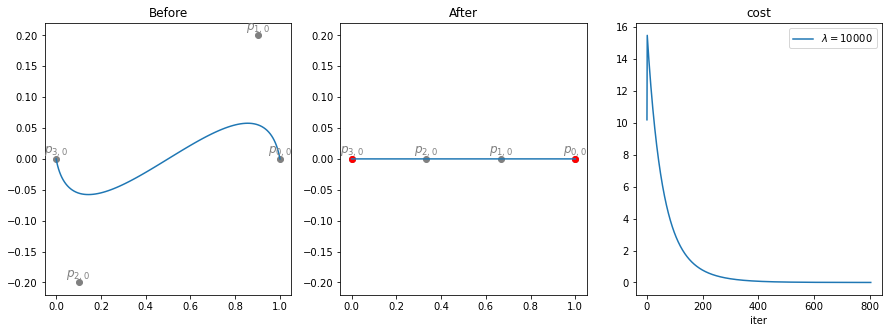

In [18]:
# 1 segments, non-periodic 
P = np.array([[1, 0], [0.9, 0.2], [0.1, -0.2], [0, 0]])
D = np.array([[1,0], [0,0]])
_ = descent_experiment(P, D, lam=10000)
plt.legend(["$\lambda = 10000$"])
plt.show()

The two plot above demonstrate the unique solution of the single Bézier curve. We get the straight line between the endpoints with control points evenly spaces for constant aceleration, thus driving the cost funtion to $0$.

We round off the subsubsection with an example where we cannot get the cost function to 0.

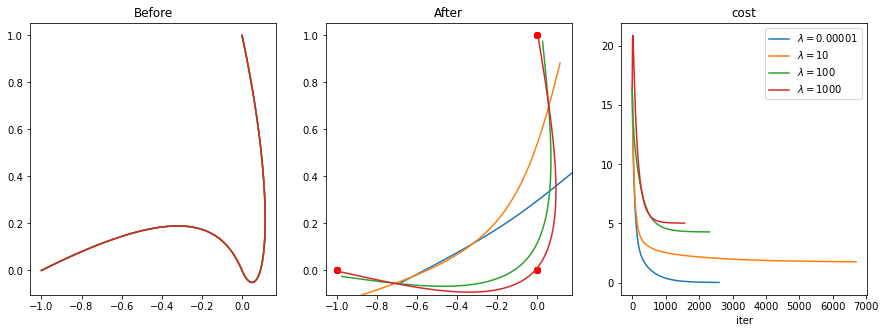

In [19]:
# Points and red knots
P = np.array([[-1, 0], [-0.3, 0.3], [0, 0], [0.1, -0.2], [0.2, 0.2], [0, 1]])
D = np.array([[-1, 0], [0,0], [0,1]])

# Lambdas for experiment
lam_list = [0.00001, 10, 100, 1000]

# Run experiment for each lambda in same plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for lam in lam_list:
    _ = descent_experiment(P, D, lam, axs=axs, show_points=False)

lam_leg = ["$\lambda = 0.00001$", "$\lambda = 10$", "$\lambda = 100$", "$\lambda = 1000$"]

plt.legend(lam_leg)
plt.show()

We see that for low lambda, we obtain one of the many near-staight lines that gives cost near 0. Avoiding such arbitrary lines was the motivation of introducing the penalisation term with $\lambda$. Larger lambda on the other hand gives us a curve that is closer to interpolationg the data points.

#### Experiments with periodic splines and the letter

We now experiment with the letter. We do one final non-letter experiment to show that the codes behaves as expected on periodic splines as well. We first define an interface to convert the letter velocities and points to the wanted format before performing the experiment. 

In [20]:
def letter_experiment(A, V, lam, maxiter=20000, h=0.0001, periodic=True, plot=True, show_points=True, axs=None):

    # Red knots
    D = A.copy()

    # Find the control points from A and V
    A_full = interpolate_periodic(A, V).reshape(-1, 2)
    P = np.array([A_full[i] for i in range(len(A_full)) if (i%4==0 or i%4==1)])

    # Perform experiment
    return descent_experiment(P, D, lam=lam, maxiter=maxiter, h=h, periodic=True, plot=plot, show_points=show_points, axs=axs)

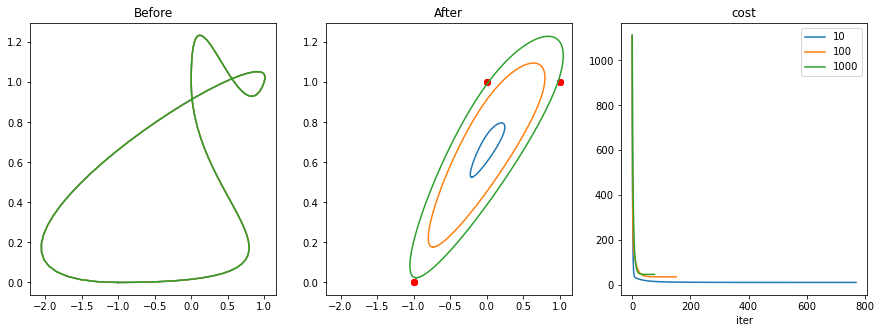

In [21]:
# Lambdas for experiment
lam_list = [10, 100, 1000]

# Run experiment for each lambda in same plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for lam in lam_list:
    _ = letter_experiment(test_A, test_V, lam, axs=axs, show_points=False, maxiter=10000, h=0.001)

lam_leg = ["$\lambda = 10$", "$\lambda = 100$", "$\lambda = 1000$"]
plt.legend(lam_list)
plt.show()

For the large lambda we see that we are near all the knots as we wanted. We also see significant reduction in curvature, which corresponds to a decrease in acceleration as expected. Referring back to previous discussion of what happens for large lambda, the priority here was clearly interpolation. The remaining 3 control points, 1 for each segment, are adjusted to solve the wild behaviour of the initial curve to get lower acceleration as well.

When investigating smaller lambda, we get as expected a sort of nesting of the result, where smaller $\lambda$ gives a smaller curve. This corresponds to less penalisation for leaving the knots behind. It also shows that we should avoid very small lambdas if don't want the letter to disappear. 

With these considerations and the tools we have developed we (finally) move on the letter. 

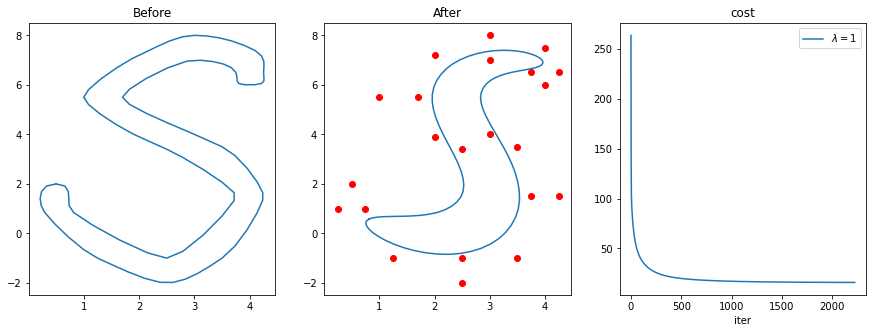

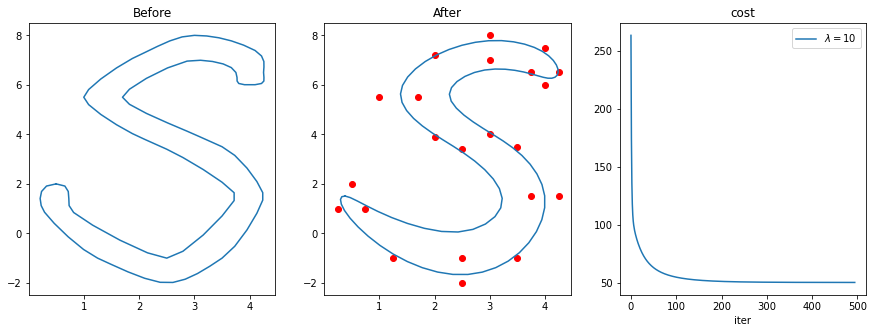

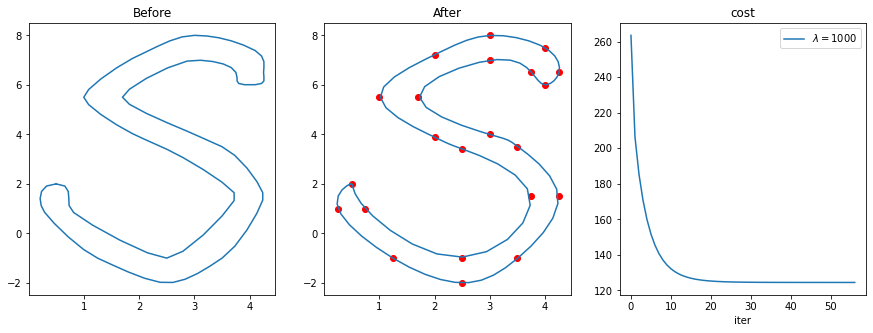

In [22]:
_ = letter_experiment(S_A, S_V, 1,    maxiter=10000, h=0.001, show_points=False)
plt.legend(["$\lambda = 1$"])
plt.show()
_ = letter_experiment(S_A, S_V, 10,   maxiter=10000, h=0.001, show_points=False)
plt.legend(["$\lambda = 10$"])
plt.show()
_ = letter_experiment(S_A, S_V, 1000, maxiter=10000, h=0.001, show_points=False)
plt.legend(["$\lambda = 1000$"])
plt.show()

Applying the optimization problem to our letter S, we find that it looks significantly improved. In all cases the S looks smoother and more like one coherent curve instead of many sharp lines stiched together like it did initially. Here we use smooth in the "every day" more subjective meaning of the word, and not the mathematical definition of smoothness. We find that the smallest $\lambda$ results in the smoothest and most asthetically pleasing curve, but it loses some of the features of the letter making it less clear that it is an actual S. Therefore we find $\lambda = 10$ to be the best in terms of loking nice and retaining the features of the letter. The last curve is also a large improvement from the original, but looks more "stiff" and rough around the edges than $\lambda = 10$.

For the cost, we remark that the final cost is seen to be an increasing function of $\lambda$. This makes sense, since larger $\lambda$ results in poorer reduction in acceleration and thus an increasing error from the integral-term. In addition comes the error from the penalisation term. We also note that low cost does not imply a good letter, as we have seen how very low lambdas makes the curve vanish. On the other hand, very low $\lambda$ results in near $0$ cost, but it is noe a good metric for how pleasing the result is. In other words, one has to use trial and error to find a favorite lambda for the letter at hand.